In [48]:
!pip install gymnasium highway-env stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached n

In [3]:
import gymnasium as gym
# import highway_env
# highway_env.register_highway_envs()

import time
import numpy as np
import pandas as pd
from collections import deque
from tqdm.notebook import tqdm
import itertools
import pickle
import random
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output

from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.monitor import Monitor

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
import tensorflow as tf

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [4]:
default_config = {
    "lanes_count" : 4,
    "vehicles_count": 50,
    "duration": 40,
    "other_vehicles_type": "highway_env.vehicle.behavior.IDMVehicle",
    "initial_spacing": 2,
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "collision_reward": -100,
    "right_lane_reward": 10,
    "high_speed_reward": 10,
    "lane_change_reward": -1,
    "reward_speed_range": [20, 30],
    "normalize_reward": False,
    "screen_width": 800,
    "screen_height": 600,
    "centering_position": [0.5, 0.5],
    "scaling": 5,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}

In [52]:
class TimeToCollision:
    def __init__(self, 
                horizon=5,
                policy_frequency=5,
                simulation_frequency=15,
                high_speed_reward=10,
                right_lane_reward=10,
                lane_change_reward=-1,
                render_mode=None):

        self.config = default_config.copy()
        self.config["observation"] =  {
                "type": "TimeToCollision",
                "horizon": horizon}
        self.horizon = horizon

        self.config.update({
            "policy_frequency": policy_frequency,
            "simulation_frequency": simulation_frequency,
            "high_speed_reward": high_speed_reward,
            "right_lane_reward": right_lane_reward,
            "lane_change_reward": lane_change_reward
        })

        with gym.make("highway-fast-v0", config=self.config, render_mode=render_mode) as env:
            self.env = env
            self.obs_space_shape = env.observation_space.shape
            self.action_space_size = env.action_space.n

    def get_state(self):
        grid = self.env.get_wrapper_attr('vehicle').speed_index
        # return self.current_obs[grid]
        return self.current_obs

    def reset(self, seed='random'):
        if seed == 'random':
            seed = np.random.randint(100000)
        self.current_obs, info = self.env.reset(seed=seed)
        return self.get_state()

    def step(self, action):
        self.current_obs, reward, done, truncated, info = self.env.step(action)
        return self.get_state(), reward, done, truncated

    def close(self):
        self.env.close()

    def action_space_sample(self):
        return self.env.action_space.sample()

    def test_env(self, sleep_time=1):
        with gym.make("highway-v0", config=self.config, render_mode='human') as env:
            self.env = env
            obs = env.reset()
            for _ in range(1000):
                action = env.action_space.sample()
                self.current_obs, reward, done, truncated, info = env.step(action)
                print(self.get_state(env), reward)
                if done:
                    break
                time.sleep(sleep_time)

In [53]:
class TimeToCollisionVec:
    def __init__(self, num_envs, **kwargs):
        self.envs = [TimeToCollision(**kwargs) for _ in range(num_envs)]
        self.num_envs = num_envs
        self.obs_space_shape = self.envs[0].obs_space_shape
        self.action_space_size = self.envs[0].action_space_size
    
    def reset(self):
        seeds = [np.random.randint(100000) for _ in range(self.num_envs)]
        return [env.reset(seed=seed) for env, seed in zip(self.envs, seeds)]
    
    def step(self, actions):
        obs, rewards, dones, truncated = [], [], [], []
        for env, action in zip(self.envs, actions):
            o, r, d, t = env.step(action)
            obs.append(o)
            rewards.append(r)
            dones.append(d)
            truncated.append(t)
        return np.array(obs), np.array(rewards), np.array(dones), np.array(truncated)
    
    def close(self):
        [env.close() for env in self.envs]        

    def test_env(self, sleep_time=1):
        obs = self.reset()
        for _ in range(10):
            actions = [env.action_space_sample() for env in self.envs]
            obs, rewards, dones, truncated = self.step(actions)
            print(obs, rewards)
            if np.all(dones):
                break
            time.sleep(sleep_time)

In [57]:
ttc = TimeToCollision()

In [60]:
b

(array([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          

In [58]:
agent = DQNAgent(env=ttc)

In [56]:
class DQNAgent:
    def __init__(self, env):
        self.env = env
        # Main model - what gets trained every step
        self.model = self.create_model()

        # Target model - what we predict every step
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()
        model.add(Conv2D(16, (2, 2), input_shape=self.env.obs_space_shape))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(Dense(64))

        model.add(Dense(self.env.action_space_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        return model

    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape), verbose=0)[0]

    def train_model(self, terminal_state):
        if len(self.replay_memory) < self.min_replay_memory:
            return

        minibatch = random.sample(self.replay_memory, self.batch_size)

        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states, verbose=0)                      # The model that gets trained every step

        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states, verbose=0)              # The model that doesn't get trained every step

        X,y = [], []

        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + self.gamma * max_future_q
            else:
                new_q = reward

            current_qs = current_qs_list[index]
            # Update the q value for the action taken
            current_qs[action] = new_q

            X.append(current_state)
            y.append(current_qs)

        self.model.fit(np.array(X), np.array(y), batch_size=self.batch_size, verbose=0, shuffle=False)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > self.update_weights_freq:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    def epsilon_greedy(self,current_state):
        if np.random.random() > self.epsilon:
            action = np.argmax(self.get_qs(current_state), axis=1)
        else:
            # Generate self.env.num_envs random actions
            action = [self.env.action_space_sample() for _ in range(self.env.num_envs)]
        return action

    def decay_eps(self):
        if self.epsilon > self.min_eps:
            self.epsilon *= self.eps_decay
            self.epsilon = max(self.min_eps, self.epsilon)

    def init(self, epsilon=1,
             min_eps=0.001,
             eps_decay=0.998,
             gamma=0.99,
             replay_memory=50_000,
             batch_size=64,
             update_weights_freq=5,
             min_replay_memory=1_000
             ):
        self.initialized = True
        self.epsilon, self.min_eps, self.eps_decay = epsilon, min_eps, eps_decay
        self.replay_memory = deque(maxlen=replay_memory)
        self.update_weights_freq = update_weights_freq
        self.min_replay_memory = min_replay_memory
        self.batch_size = batch_size
        self.gamma = gamma
        self.current_episode, self.step = 0, 0
        self.ep_rewards, self.mean_rw_history, self.mean_steps_history = [], [], []

    def train(self, episodes=10_000, evaluation_freq=25):
        if not self.initialized:
          print('Warning! Initializing with default parameters')
          self.init()

        start_time = time.time()
        for episode in tqdm(range(self.current_episode, episodes+1), unit='episode'):
            current_state = self.env.reset(seed=np.random.randint(100000))
            done, episode_reward = False, 0
            self.current_episode += 1
            # Episode cycle
            while not done:
                action = self.epsilon_greedy(current_state)
                new_state, reward, done, truncate = self.env.step(action)
                done = done | truncate
                episode_reward += reward

                self.update_replay_memory((current_state, action, reward, new_state, done))
                self.train_model(done)

                current_state = new_state
                self.step += 1

            self.ep_rewards.append(episode_reward)

            if self.current_episode % evaluation_freq == 0:
                rewards_mean, steps_mean = self.evaluate(self, n_games=10, t_max=200)
                self.mean_rw_history.append(rewards_mean)
                self.mean_steps_history.append(steps_mean)

                clear_output(True)

                print(f"episode = {self.current_episode}, epsilon = {self.epsilon}, mean reward = {rewards_mean}, mean steps = {steps_mean}")
                print(f"total steps = {self.step}, time_elapsed = {time.time() - start_time}, fps = {self.step / (time.time() - start_time)}")
                
                plt.figure(figsize=[16, 5])
                plt.subplot(1, 2, 1)
                plt.title("Mean reward per episode")
                plt.plot(self.mean_rw_history)
                plt.grid()

                plt.subplot(1, 2, 2)
                plt.title("Mean steps per episode")
                plt.plot(self.mean_steps_history)
                plt.grid()

                plt.show()

            self.decay_eps()

    def evaluate(self, agent, n_games=3, t_max=1000, render=True, verbose=True):
        sim_freq, pol_freq, horizon = self.env.config['simulation_frequency'], self.env.config['policy_frequency'], self.env.horizon
        render_mode = 'human' if render else None
        ttc_env = TimeToCollision(policy_frequency=pol_freq, simulation_frequency=sim_freq, horizon=horizon, render_mode=render_mode)

        print('Evaluating...') if verbose else None
        rewards, steps_array = [], []
        for i in tqdm(range(n_games)):
            cum_reward = 0
            steps, done = 0, False
            current_state = ttc_env.reset(seed=np.random.randint(100000))
            while not done and steps < t_max:
                # Get next action
                next_action = np.argmax(agent.get_qs(current_state))
                current_state, reward, done, truncated = ttc_env.step(next_action)
                done = done | truncated
                cum_reward += reward
                steps += 1
            rewards.append(cum_reward)
            steps_array.append(steps)

        ttc_env.close()
        return np.mean(rewards), np.mean(steps_array)

episode = 225, epsilon = 0.6386181367981257, mean reward = 968.1273931847827, mean steps = 57.0
total steps = 10127, time_elapsed = 4120.967234134674, fps = 2.4574327881368077


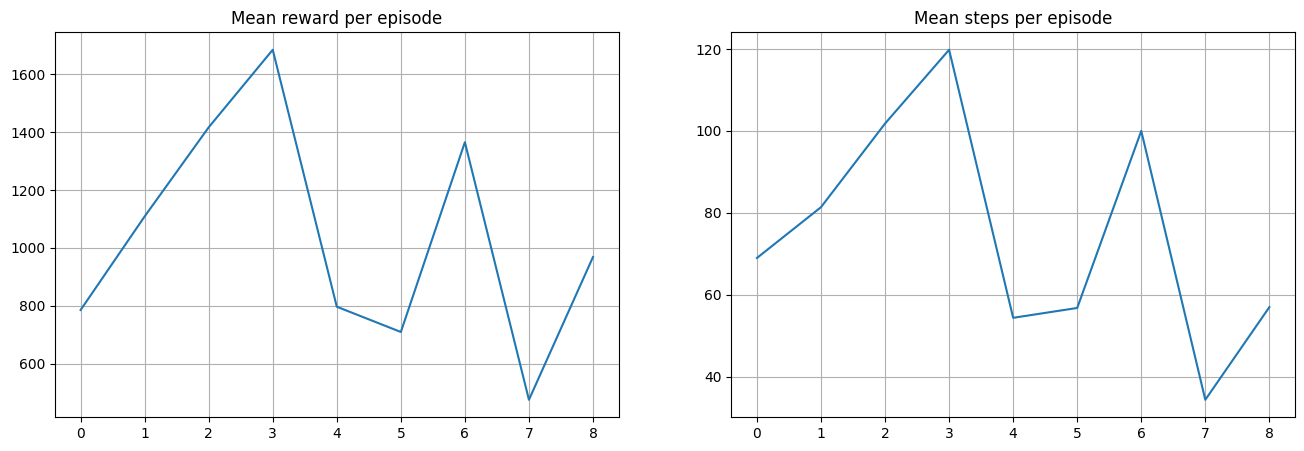

KeyboardInterrupt: 

In [13]:
ttc = TimeToCollision(horizon=10, policy_frequency=5, simulation_frequency=15)
agent = DQNAgent(ttc)
agent.init(
    epsilon=1,
    min_eps=0.01,
    eps_decay=0.998,
    gamma=0.99,
    replay_memory=50_000,
    batch_size=64,
    update_weights_freq=5,
    min_replay_memory=1_000
)

agent.train(episodes=2000, evaluation_freq=25)

In [51]:
config = {
    "observation": {
        "type": "TimeToCollision"
    },
    "vehicles_count": 50,
    "duration": 120,
    "policy_frequency": 5,
    "simulation_frequency": 15
}
env = gym.make("highway-fast-v0")
env.configure(config)
env.reset()

model = DQN(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=50000,
    learning_starts=1000,
    batch_size=32,
    tau=1.0,
    gamma=0.99,
    train_freq=4,
    gradient_steps=1,
    target_update_interval=1000,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1
)

# Definieren Sie einen Checkpoint-Callback
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/', name_prefix='dqn_model')

# Trainieren Sie das Modell
model.learn(total_timesteps=100000, callback=checkpoint_callback)

# Speichern Sie das Modell
model.save("dqn_highway")

# Laden Sie das Modell
model = DQN.load("dqn_highway")


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.configure to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.configure` for environment variables or `env.get_wrapper_attr('configure')` that will search the reminding wrappers.
  logger.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 99.5     |
|    ep_rew_mean      | 80.7     |
|    exploration_rate | 0.961    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 79       |
|    time_elapsed     | 5        |
|    total_timesteps  | 398      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 94.4     |
|    ep_rew_mean      | 76       |
|    exploration_rate | 0.926    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 90       |
|    time_elapsed     | 8        |
|    total_timesteps  | 755      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 92.2     |
|    ep_rew_mean      | 75.5  

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

In [56]:
env = gym.make("highway-fast-v0", render_mode="human", config=config)

while True:
  done = truncated = False
  obs, info = env.reset()
  while not (done or truncated):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)
    env.render()

env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 